### load packages

In [1]:
import sys
sys.path.append('..') # add parent directory to path

import numpy as np 
import pandas as pd
from utils import processing as pr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
# data in .parquet format, method for loading requires pyarrow and fastparquet
#! pip install pyarrow fastparquet

### load data for month of choice
I created a loading file that directly loads the data files from the NYC TLC website. You can input month and year as either value types or string types. Here, we load only the `yellow` taxi data.

# Yellow Taxi

In [3]:
def load_and_process_data(month, year, vehicle_type = 'yellow'):
    # load data
    df = pr.load_taxi_data(month = month, year = year, vehicle_type = 'yellow')
    if vehicle_type == 'yellow':
        # split datetime into data and time
        df.rename(
            columns = {'tpep_pickup_datetime': 'pickup_datetime',
                    'tpep_dropoff_datetime': 'dropoff_datetime'}, 
            inplace = True
        )
        # remove rows outside of month and year
        df = df[(df.pickup_datetime.dt.month == month) & (df.pickup_datetime.dt.year == year)]
    return df
    

In [4]:
months = np.arange(1,3+1,1)
years = np.arange(2022,2022+1,1)
month_year = np.meshgrid(years, months)
month_year = np.array(month_year).T.reshape(-1,2)
df_list = []
for year, month in tqdm(month_year): # can use itertools.product, but got this working faster
    df = load_and_process_data(month, year)
    df_list.append(df)
df = pd.concat(df_list, ignore_index = True)

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:05<00:00,  1.92s/it]


In [5]:
print('Three Months Unbinned Memory Usage (MB): ', df.memory_usage().sum() / 1024**2)

Three Months Unbinned Memory Usage (MB):  1314.9242973327637


In [3]:
def load_and_process_data(month, year, vehicle_type = 'yellow'):
    # load data
    df = pr.load_taxi_data(month = month, year = year, vehicle_type = 'yellow')

    # processing
    if vehicle_type == 'yellow':
        # split datetime into data and time
        df.rename(
            columns = {'tpep_pickup_datetime': 'pickup_datetime',
                    'tpep_dropoff_datetime': 'dropoff_datetime'}, 
            inplace = True
        )

    # remove rows outside of month and year
    df = df[(df.pickup_datetime.dt.month == month) & (df.pickup_datetime.dt.year == year)]

    # bin data by hour and timezone
    ts_h_y_z = df.set_index('pickup_datetime').groupby(['PULocationID', pd.Grouper(freq='h')]).size() # group by hour and location
    ts_H_y_z = ts_h_y_z.to_frame(name = 'counts') # convert to dataframe 
    ts_H_y_z = ts_H_y_z.unstack(level=0).fillna(0) # unstack to obtain missing hours as NaNs, fill missing rides with 0
    ts_H_y_z.index = ts_H_y_z.index.tz_localize('America/New_York', ambiguous = True) # need to localize timezone for time to appear
    ts_H_y_z = ts_H_y_z.stack(future_stack = True) # undo the unstacking
    ts_H_y_z = ts_H_y_z.swaplevel() # swap indices so location is first
    ts_H_y_z = ts_H_y_z.reset_index() # remove the stacked structure to have standard dataframe with rows and columns only
    ts_H_y_z.sort_values(by = ['PULocationID', 'pickup_datetime'], inplace = True) # sort by location and time

    return ts_H_y_z
    

In [4]:
months = np.arange(1,3+1,1)
years = np.arange(2023,2023+1,1)
# months = np.arange(1,12+1,1)
# years = np.arange(2022,2023+1,1)
month_year = np.meshgrid(years, months)
month_year = np.array(month_year).T.reshape(-1,2)
ts_list = []
for year, month in tqdm(month_year): # can use itertools.product, but got this working faster
    ts = load_and_process_data(month, year)
    ts_list.append(ts)
ts = pd.concat(ts_list, ignore_index = False).reset_index()

100%|██████████| 3/3 [00:13<00:00,  4.51s/it]


In [5]:
ts

,index,PULocationID,pickup_datetime,counts
0,0,1,2023-01-01 00:00:00-05:00,0.0
1,257,1,2023-01-01 01:00:00-05:00,0.0
2,514,1,2023-01-01 02:00:00-05:00,0.0
3,771,1,2023-01-01 03:00:00-05:00,0.0
4,1028,1,2023-01-01 04:00:00-05:00,0.0
...,...,...,...,...
558502,64205,265,2023-03-31 19:00:00-04:00,6.0
558503,63683,265,2023-03-31 20:00:00-04:00,6.0
558504,72818,265,2023-03-31 21:00:00-04:00,11.0
558505,175652,265,2023-03-31 22:00:00-04:00,1.0


In [6]:
# remove index column
ts = ts.drop(columns = 'index')

In [7]:
print('Three Months Unbinned Memory Usage (MB): ', ts.memory_usage().sum() / 1024**2)

Three Months Unbinned Memory Usage (MB):  12.783336639404297


In [8]:
ts_1 = ts[ts['PULocationID'] == 79]

<Axes: xlabel='pickup_datetime'>

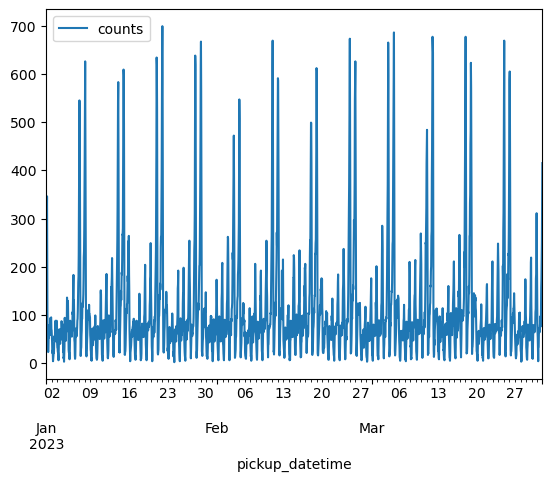

In [9]:
ts_1.plot(x = 'pickup_datetime', y = 'counts')

In [10]:
ts_1_p = ts_1.set_index('pickup_datetime')
ts_1_p.drop(columns = 'PULocationID', inplace = True)
# ts_1_p.reset_index(inplace = True)

In [11]:
ts_1_p

,counts
pickup_datetime,
2023-01-01 00:00:00-05:00,292.0
2023-01-01 01:00:00-05:00,308.0
2023-01-01 02:00:00-05:00,298.0
2023-01-01 03:00:00-05:00,346.0
2023-01-01 04:00:00-05:00,223.0
...,...
2023-03-31 19:00:00-04:00,175.0
2023-03-31 20:00:00-04:00,213.0
2023-03-31 21:00:00-04:00,250.0


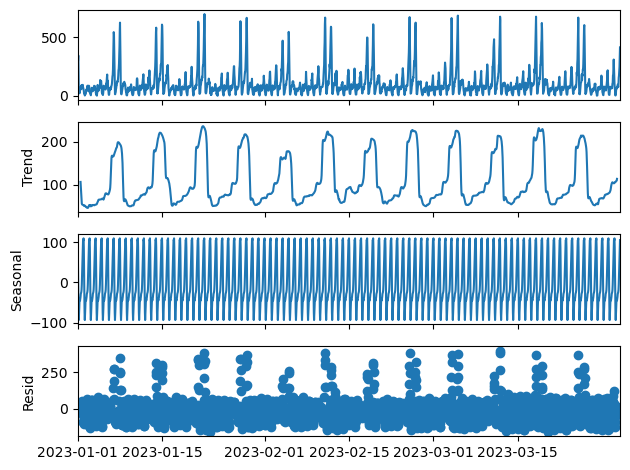

In [15]:
# seasonality decomposition 
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts_1_p, model='additive', period = 24)
decomposition.plot()
plt.show()

In [19]:
from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.seasonal import DecomposeResult

mstl = MSTL(ts_1_p["counts"], periods=[24, 24 * 7])
res = mstl.fit()

In [20]:
res.seasonal.head()

,seasonal_24,seasonal_168
pickup_datetime,,
2023-01-01 00:00:00-05:00,7.585616,308.359910
2023-01-01 01:00:00-05:00,-5.343706,349.587863
2023-01-01 02:00:00-05:00,3.109272,299.167307
2023-01-01 03:00:00-05:00,49.630455,204.154550
2023-01-01 04:00:00-05:00,19.016856,92.928741


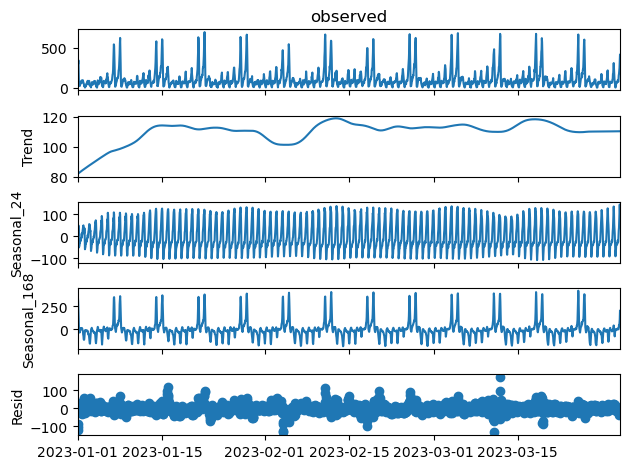

In [21]:
ax = res.plot()

In [34]:
mstl = MSTL(
    ts_1_p["counts"],
    periods=[24, 24 * 7],  # The periods and windows must be the same length and will correspond to one another.
    windows=[101, 101],  # Setting this large along with `seasonal_deg=0` will force the seasonality to be periodic.
    iterate=3,
    stl_kwargs={
                "trend":19, # Setting this large will force the trend to be smoother.
                "seasonal_deg":0, # Means the seasonal smoother is fit with a moving average.
               }
)

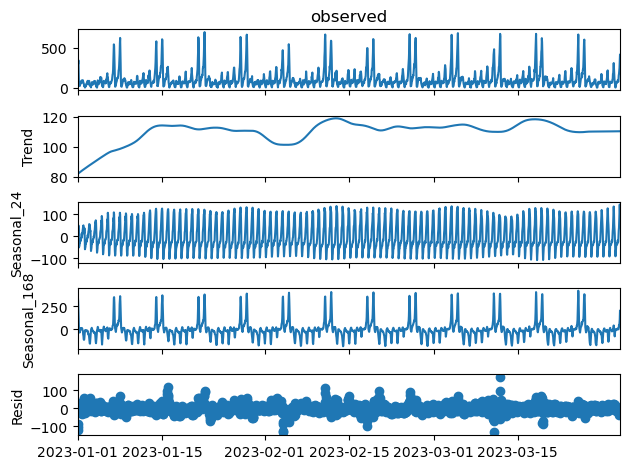

In [35]:
ax = res.plot()

<Axes: xlabel='pickup_datetime'>

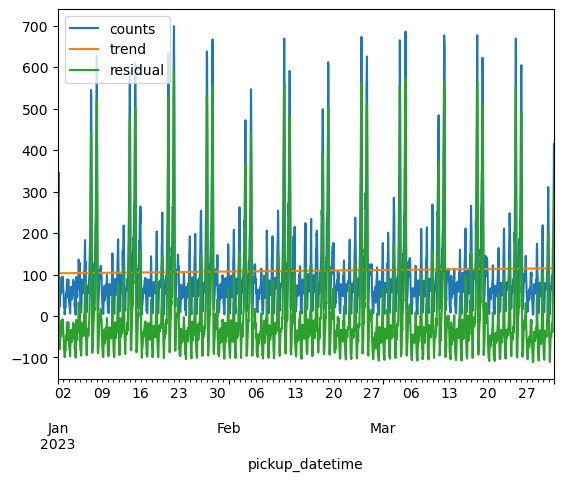

In [60]:
! pip install scikit-learn
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(np.arange(len(ts_1_p)).reshape(-1,1), ts_1_p['counts'])
ts_1_p['trend'] = lm.predict(np.arange(len(ts_1_p)).reshape(-1,1))

ts_1_p['residual'] = ts_1_p['counts'] - ts_1_p['trend']

ts_1_p

ts_1_p.plot(y = ['counts', 'trend', 'residual'])

In [61]:
from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.seasonal import DecomposeResult

mstl = MSTL(ts_1_p["residual"], periods=[24, 24 * 7, 24 * 10])
res = mstl.fit()

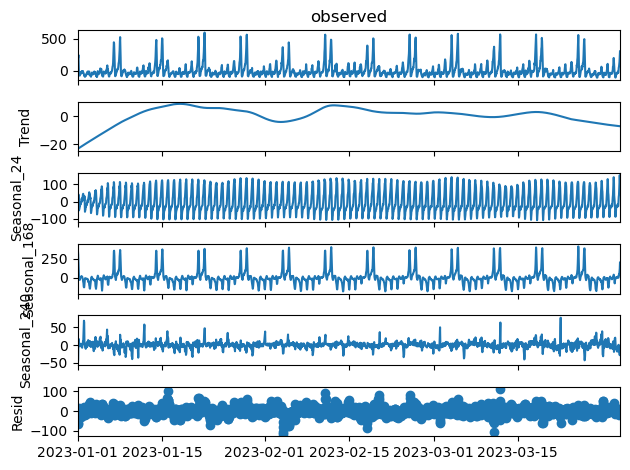

In [62]:
ax = res.plot()

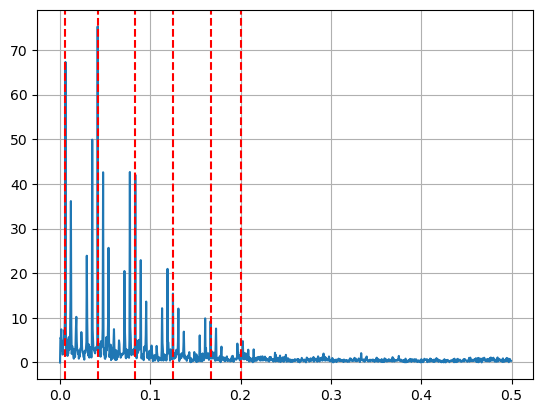

In [63]:
# compute fft of residuals
from scipy.fft import fft, fftfreq

N = len(ts_1_p)
T = 1.
x = np.arange(N)
y = ts_1_p['residual'].values
yf = fft(y)
xf = fftfreq(N, T)[:N//2]

plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.axvline(x = 1/24, color = 'red', linestyle = '--')
plt.axvline(x = 1/(24*7), color = 'red', linestyle = '--')
plt.axvline(x = 1/12, color = 'red', linestyle = '--')
plt.axvline(x = 1/6, color = 'red', linestyle = '--')
plt.axvline(x = 1/8, color = 'red', linestyle = '--')
plt.axvline(x = 1/5, color = 'red', linestyle = '--')

In [64]:
from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.seasonal import DecomposeResult

mstl = MSTL(ts_1_p["residual"], periods=[24, 24 * 7, 12, 8, 6, 5])
res = mstl.fit()

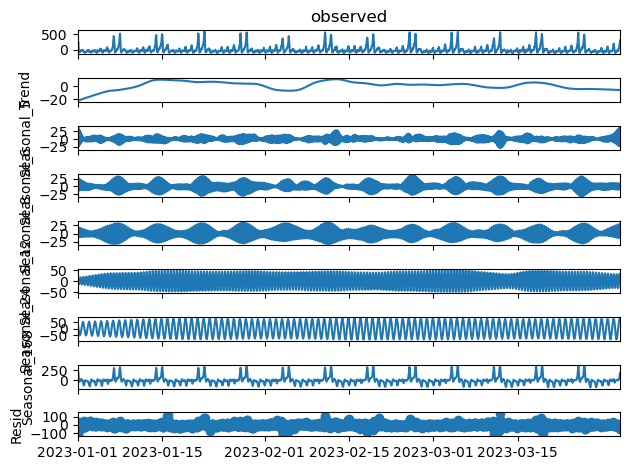

In [65]:
ax = res.plot()

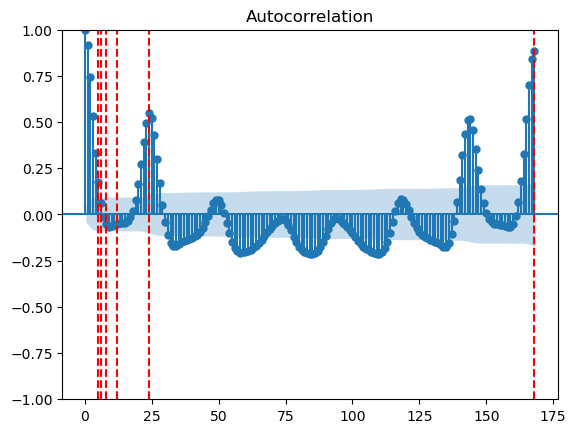

In [66]:
# compute autocorrelation of time series
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(ts_1_p['residual'], lags = 24*7)
plt.axvline(x = 24, color = 'red', linestyle = '--')
plt.axvline(x = 24*7, color = 'red', linestyle = '--')
plt.axvline(x = 12, color = 'red', linestyle = '--')
plt.axvline(x = 8, color = 'red', linestyle = '--')
plt.axvline(x = 6, color = 'red', linestyle = '--')
plt.axvline(x = 5, color = 'red', linestyle = '--')

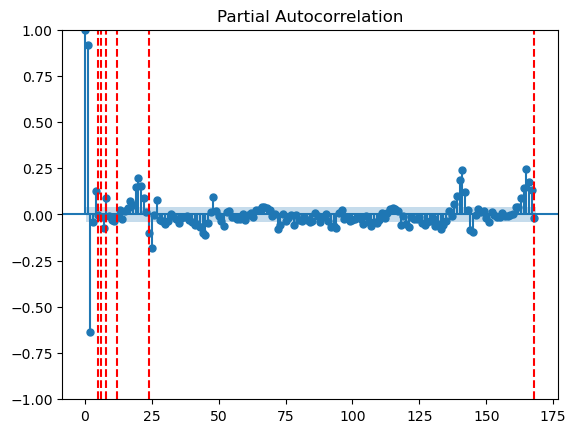

In [67]:
# compute autocorrelation of time series
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(ts_1_p['residual'], lags = 24*7)
plt.axvline(x = 24, color = 'red', linestyle = '--')
plt.axvline(x = 24*7, color = 'red', linestyle = '--')
plt.axvline(x = 12, color = 'red', linestyle = '--')
plt.axvline(x = 8, color = 'red', linestyle = '--')
plt.axvline(x = 6, color = 'red', linestyle = '--')
plt.axvline(x = 5, color = 'red', linestyle = '--')

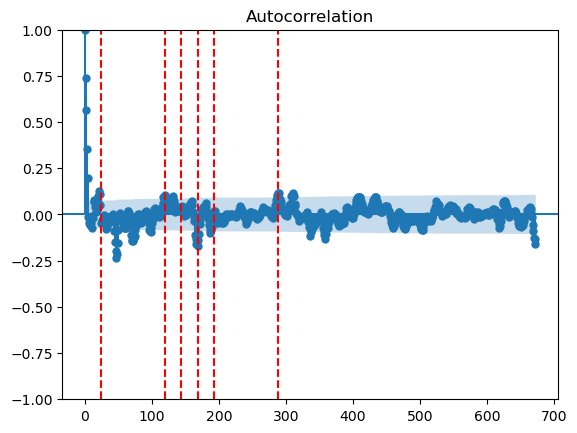

In [73]:
# compute autocorrelation of residuals from mstl fit
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(res.resid, lags = 24*7*4)
plt.axvline(x = 24, color = 'red', linestyle = '--')
plt.axvline(x = 24*7, color = 'red', linestyle = '--')
plt.axvline(x = 24*12, color = 'red', linestyle = '--')
plt.axvline(x = 24*8, color = 'red', linestyle = '--')
plt.axvline(x = 24*6, color = 'red', linestyle = '--')
plt.axvline(x = 24*5, color = 'red', linestyle = '--')

/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                             counts   No. Observations:                 2159
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 24)   Log Likelihood              -10565.004
Date:                            Sat, 13 Jul 2024   AIC                          21140.008
Time:                                    20:40:04   BIC                          21168.337
Sample:                                01-01-2023   HQIC                         21150.376
                                     - 03-31-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4274      0.027     15.979      0.000       0.375       0.480
ma.L1          0.0662      0.029   

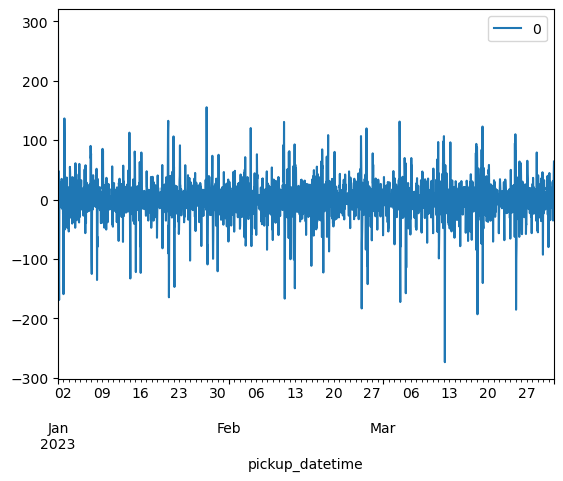

In [78]:
# fit SARIMA model

from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(ts_1_p['counts'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))
model_fit = model.fit(disp=False)
print(model_fit.summary())

# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()


In [81]:
! pip install pmdarima

  Using cached Cython-3.0.10-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.2 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 17.6 MB/s eta 0:00:00a 0:00:01
Using cached Cython-3.0.10-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.5 MB)


In [20]:
from pmdarima.preprocessing import FourierFeaturizer
from pmdarima import auto_arima

# Prepare the fourier terms to add as exogenous features to auto_arima
# Annual seasonality covered by fourier terms
four_terms = FourierFeaturizer(24*7, 1)
y_prime, exog = four_terms.fit_transform(ts_1_p['counts'])
exog['pickup_date'] = y_prime.index # is exactly the same as manual calculation in the above cells
exog = exog.set_index(exog['pickup_date'])
exog = exog.drop(columns=['pickup_date'])

In [23]:
exog

,FOURIER_S168-0,FOURIER_C168-0
pickup_date,,
2023-01-01 00:00:00-05:00,0.037391,0.999301
2023-01-01 01:00:00-05:00,0.074730,0.997204
2023-01-01 02:00:00-05:00,0.111964,0.993712
2023-01-01 03:00:00-05:00,0.149042,0.988831
2023-01-01 04:00:00-05:00,0.185912,0.982566
...,...,...
2023-03-31 19:00:00-04:00,-0.884114,0.467272
2023-03-31 20:00:00-04:00,-0.866024,0.500003
2023-03-31 21:00:00-04:00,-0.846722,0.532035


/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.17169D+00    |proj g|=  7.77864D-01

At iterate    5    f=  4.90603D+00    |proj g|=  1.28940D-01

At iterate   10    f=  4.88605D+00    |proj g|=  1.26185D-01

At iterate   15    f=  4.85196D+00    |proj g|=  2.53281D-02

At iterate   20    f=  4.84799D+00    |proj g|=  2.68400D-03

At iterate   25    f=  4.84651D+00    |proj g|=  1.02331D-02

At iterate   30    f=  4.84502D+00    |proj g|=  3.47834D-03

At iterate   35    f=  4.84497D+00    |proj g|=  1.48532D-03

At iterate   40    f=  4.84496D+00    |proj g|=  9.84438D-04

At iterate   45    f=  4.84488D+00    |proj g|=  3.30253D-03


/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.84485D+00    |proj g|=  1.41227D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21     50     55      1     0     0   1.412D-04   4.845D+00
  F =   4.8448516420777556     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
                               SARIMAX Results                                
Dep. Variable:                 counts   No. Observations:                 2159
Model:               SARIMAX(7, 1, 3)   Log Likelihood              -10460.035
Date:                Sat, 13 Jul 2024   AIC                          20962.069
Time:                        22:31:28   BIC  

/tmp/ipykernel_20961/3373389469.py:37: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_index = pd.date_range(start=ts_data.index[-1], periods=1000, freq='H')[1:]


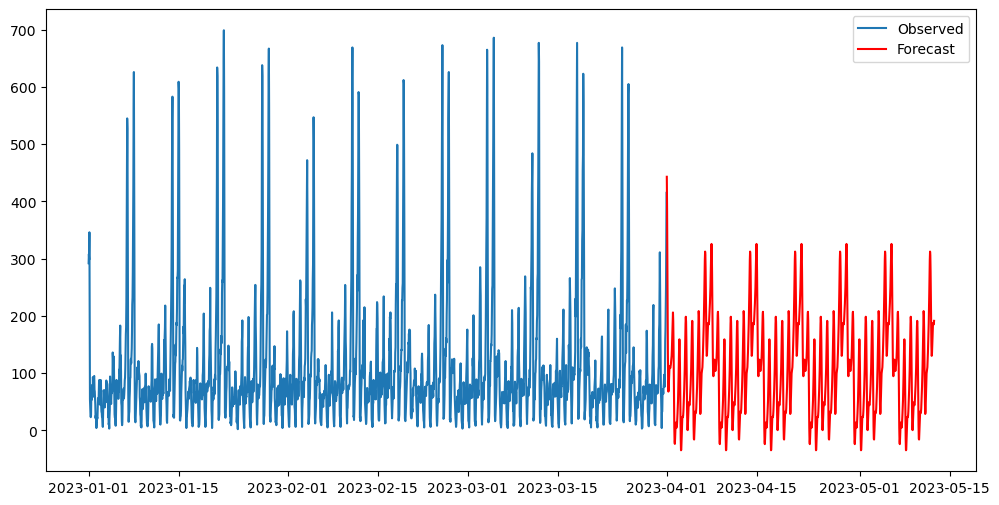

In [68]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Example time series data (counts per hour for one week)
# Replace this array with your actual data
ts_data = ts_1_p['counts']

def create_fourier_terms(series, period, K):
    t = np.arange(len(series))
    terms = pd.DataFrame({
        f'sin_{i}': np.sin(2 * np.pi * i * t / period) for i in range(1, K + 1)
    }).join(pd.DataFrame({
        f'cos_{i}': np.cos(2 * np.pi * i * t / period) for i in range(1, K + 1)
    }))
    return terms

# Create Fourier terms for daily (24-hour) and weekly (168-hour) seasonality
daily_fourier = create_fourier_terms(ts_data, period=24, K=3)
weekly_fourier = create_fourier_terms(ts_data, period=24*7, K=2)

# Combine exogenous variables
exog = pd.concat([daily_fourier, weekly_fourier], axis=1)
exog.index = ts_data.index

# Fit SARIMAX model with exogenous variables for multiple seasonalities
sarimax_model = sm.tsa.statespace.SARIMAX(ts_data, order=(7, 1, 3), exog=exog).fit()

# Print model summary
print(sarimax_model.summary())

# Forecasting
future_exog = pd.concat([create_fourier_terms(ts_data, period=24, K=3).iloc[:1000],
                         create_fourier_terms(ts_data, period=24*7, K=2).iloc[:1000]], axis=1)
forecast = sarimax_model.get_forecast(steps=1000, exog=future_exog)
forecast_index = pd.date_range(start=ts_data.index[-1], periods=1000, freq='H')[1:]
forecast_series = pd.Series(forecast.predicted_mean, index=forecast_index)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(ts_data, label='Observed')
plt.plot(forecast_series, label='Forecast', color='red')
plt.legend()
plt.show()



/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.27863D-01    |proj g|=  5.93625D-02

At iterate    5    f=  5.23797D-01    |proj g|=  2.67423D-04

At iterate   10    f=  5.23790D-01    |proj g|=  3.12103D-03

At iterate   15    f=  5.21027D-01    |proj g|=  6.97040D-03

At iterate   20    f=  5.20877D-01    |proj g|=  3.83387D-03

At iterate   25    f=  5.20687D-01    |proj g|=  7.81920D-03

At iterate   30    f=  5.19711D-01    |proj g|=  3.24837D-02

At iterate   35    f=  5.19112D-01    |proj g|=  1.70445D-03

At iterate   40    f=  5.18993D-01    |proj g|=  1.53556D-03

At iterate   45    f=  5.18961D-01    |proj g|=  1.39545D-03

At iterate   50    f=  5.18960D-01    |proj g|=  2.10957D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/tmp/ipykernel_20961/1727367151.py:38: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_index = pd.date_range(start=ts_data.index[-1], periods=1000, freq='H')[1:]


                               SARIMAX Results                                
Dep. Variable:             log_counts   No. Observations:                 2159
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1120.435
Date:                Sat, 13 Jul 2024   AIC                           2266.870
Time:                        22:37:57   BIC                           2340.670
Sample:                    01-01-2023   HQIC                          2293.863
                         - 03-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sin_1         -0.7493      0.070    -10.678      0.000      -0.887      -0.612
sin_2         -0.3917      0.038    -10.440      0.000      -0.465      -0.318
sin_3          0.0467      0.023      2.013      0.0

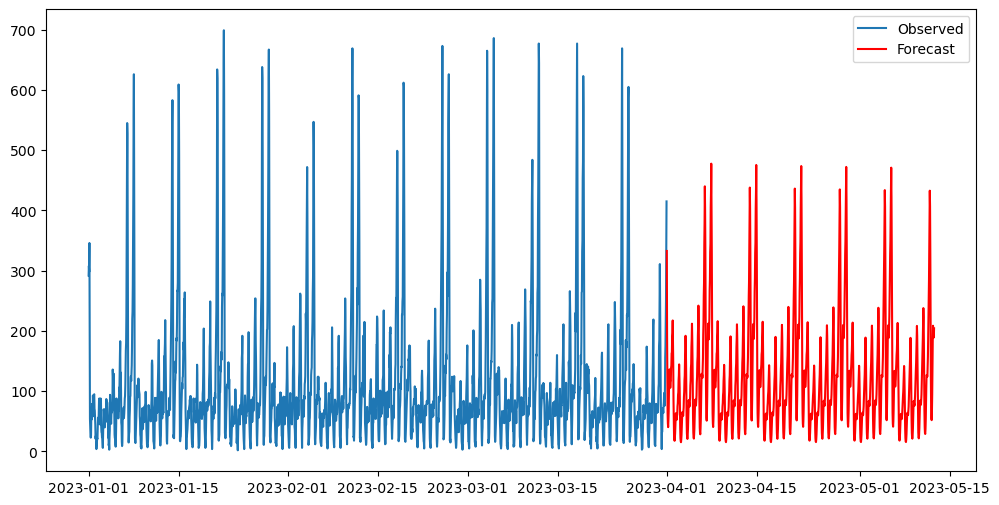

In [83]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Example time series data (counts per hour for one week)
# Replace this array with your actual data
ts_1_p['log_counts'] = np.log(ts_1_p['counts'])
ts_data = ts_1_p['log_counts']

def create_fourier_terms(series, period, K):
    t = np.arange(len(series))
    terms = pd.DataFrame({
        f'sin_{i}': np.sin(2 * np.pi * i * t / period) for i in range(1, K + 1)
    }).join(pd.DataFrame({
        f'cos_{i}': np.cos(2 * np.pi * i * t / period) for i in range(1, K + 1)
    }))
    return terms

# Create Fourier terms for daily (24-hour) and weekly (168-hour) seasonality
daily_fourier = create_fourier_terms(ts_data, period=24, K=3)
weekly_fourier = create_fourier_terms(ts_data, period=24*7, K=2)

# Combine exogenous variables
exog = pd.concat([daily_fourier, weekly_fourier], axis=1)
exog.index = ts_data.index

# Fit SARIMAX model with exogenous variables for multiple seasonalities
sarimax_model = sm.tsa.statespace.SARIMAX(ts_data, order=(1, 1, 1), exog=exog).fit()

# Print model summary
print(sarimax_model.summary())

# Forecasting
future_exog = pd.concat([create_fourier_terms(ts_data, period=24, K=3).iloc[:1000],
                         create_fourier_terms(ts_data, period=24*7, K=2).iloc[:1000]], axis=1)
forecast = sarimax_model.get_forecast(steps=1000, exog=future_exog)
forecast_index = pd.date_range(start=ts_data.index[-1], periods=1000, freq='H')[1:]
forecast_series = pd.Series(forecast.predicted_mean, index=forecast_index)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(np.exp(ts_data), label='Observed')
plt.plot(np.exp(forecast_series), label='Forecast', color='red')
plt.legend()
plt.show()



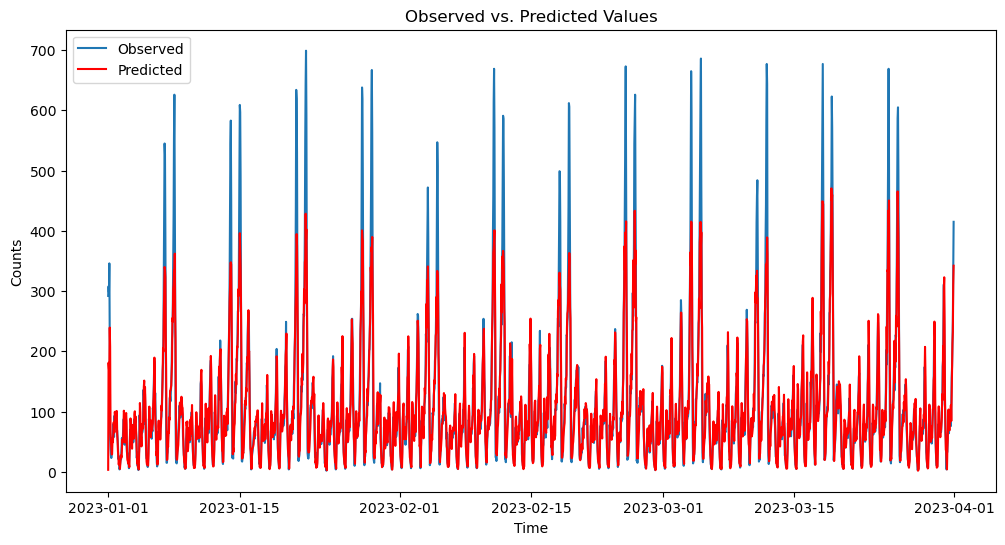

In [86]:
# Generate in-sample predictions
in_sample_predictions = sarimax_model.get_prediction(start=0, end=len(ts_data)-1, exog=exog)
predicted_mean = in_sample_predictions.predicted_mean

# Calculate residuals
residuals = ts_data - predicted_mean

# Plot observed vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(np.exp(ts_data), label='Observed')
plt.plot(np.exp(predicted_mean), label='Predicted', color='red')
plt.legend()
plt.title('Observed vs. Predicted Values')
plt.xlabel('Time')
plt.ylabel('Counts')
plt.show()

/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.70281D-01    |proj g|=  5.05365D-02

At iterate    5    f=  4.66611D-01    |proj g|=  7.36931D-04

At iterate   10    f=  4.66561D-01    |proj g|=  6.60033D-03

At iterate   15    f=  4.64617D-01    |proj g|=  3.00971D-02

At iterate   20    f=  4.64405D-01    |proj g|=  1.19004D-02

At iterate   25    f=  4.63777D-01    |proj g|=  8.80284D-03

At iterate   30    f=  4.63202D-01    |proj g|=  7.67017D-03

At iterate   35    f=  4.62744D-01    |proj g|=  9.74395D-03

At iterate   40    f=  4.62504D-01    |proj g|=  1.69095D-03

At iterate   45    f=  4.62414D-01    |proj g|=  8.91556D-04


/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.62399D-01    |proj g|=  2.37140D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     50     58      1     0     0   2.371D-03   4.624D-01
  F =  0.46239887338285585     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
                               SARIMAX Results                                
Dep. Variable:             log_counts   No. Observations:                 2159
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -998.319
Date:                Sat, 13 Jul 2024   AIC                           2042.638
Time:                        22:42:53   BIC  

/tmp/ipykernel_20961/656220039.py:38: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_index = pd.date_range(start=ts_data.index[-1], periods=1000, freq='H')[1:]


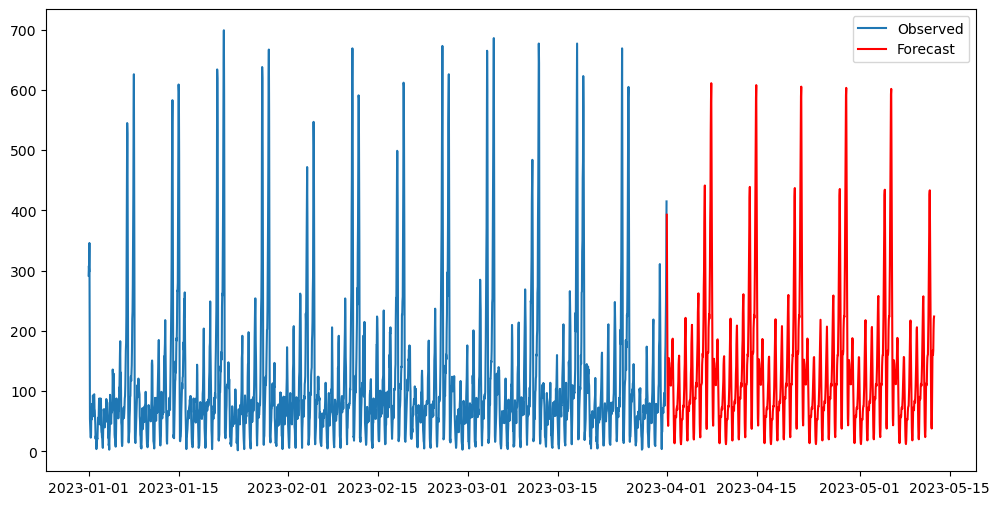

In [96]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Example time series data (counts per hour for one week)
# Replace this array with your actual data
ts_1_p['log_counts'] = np.log(ts_1_p['counts'])
ts_data = ts_1_p['log_counts']

def create_fourier_terms(series, period, K):
    t = np.arange(len(series))
    terms = pd.DataFrame({
        f'sin_{i}': np.sin(2 * np.pi * i * t / period) for i in range(1, K + 1)
    }).join(pd.DataFrame({
        f'cos_{i}': np.cos(2 * np.pi * i * t / period) for i in range(1, K + 1)
    }))
    return terms

# Create Fourier terms for daily (24-hour) and weekly (168-hour) seasonality
daily_fourier = create_fourier_terms(ts_data, period=24, K=5)
weekly_fourier = create_fourier_terms(ts_data, period=24*7, K=5)

# Combine exogenous variables
exog = pd.concat([daily_fourier, weekly_fourier], axis=1)
exog.index = ts_data.index

# Fit SARIMAX model with exogenous variables for multiple seasonalities
sarimax_model = sm.tsa.statespace.SARIMAX(ts_data, order=(1, 1, 1), exog=exog).fit()

# Print model summary
print(sarimax_model.summary())

# Forecasting
future_exog = pd.concat([create_fourier_terms(ts_data, period=24, K=5).iloc[:1000],
                         create_fourier_terms(ts_data, period=24*7, K=5).iloc[:1000]], axis=1)
forecast = sarimax_model.get_forecast(steps=1000, exog=future_exog)
forecast_index = pd.date_range(start=ts_data.index[-1], periods=1000, freq='H')[1:]
forecast_series = pd.Series(forecast.predicted_mean, index=forecast_index)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(np.exp(ts_data), label='Observed')
plt.plot(np.exp(forecast_series), label='Forecast', color='red')
plt.legend()
plt.show()



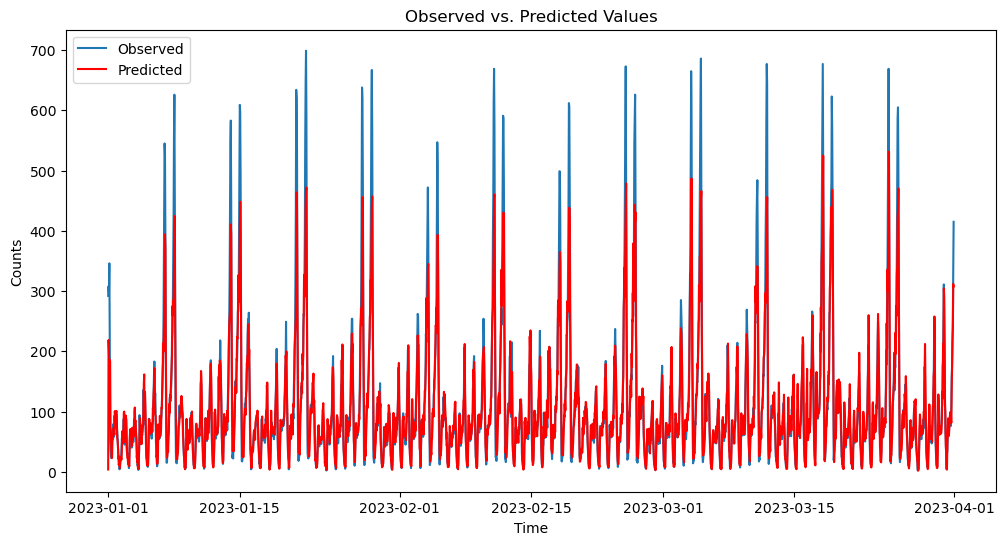

In [97]:
# Generate in-sample predictions
in_sample_predictions = sarimax_model.get_prediction(start=0, end=len(ts_data)-1, exog=exog)
predicted_mean = in_sample_predictions.predicted_mean

# Calculate residuals
residuals = ts_data - predicted_mean

# Plot observed vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(np.exp(ts_data), label='Observed')
plt.plot(np.exp(predicted_mean), label='Predicted', color='red')
plt.legend()
plt.title('Observed vs. Predicted Values')
plt.xlabel('Time')
plt.ylabel('Counts')
plt.show()

/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           64     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.28573D-01    |proj g|=  1.25203D-01

At iterate    5    f=  4.22364D-01    |proj g|=  6.98517D-02

At iterate   10    f=  4.20763D-01    |proj g|=  7.83450D-02

At iterate   15    f=  4.20336D-01    |proj g|=  8.54291D-02

At iterate   20    f=  4.20048D-01    |proj g|=  6.61944D-02

At iterate   25    f=  4.19926D-01    |proj g|=  5.05307D-02

At iterate   30    f=  4.19726D-01    |proj g|=  5.27263D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   64     34     82      1     0     0   7.937D-02   4.197D-01
  F =  0.41969460644327505     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                               SARIMAX Results                                
Dep. Variable:             log_counts   No. Observations:                 2159
Model:               SARIMAX(2, 1, 1)   Log Likelihood                -906.121
Date:                Sat, 13 Jul 2024   AIC                           1940.241
Time:                        22:46:30   BIC                           2303.565
Sample:                    0

/tmp/ipykernel_20961/4116601262.py:36: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_index = pd.date_range(start=ts_data.index[-1], periods=1000, freq='H')[1:]


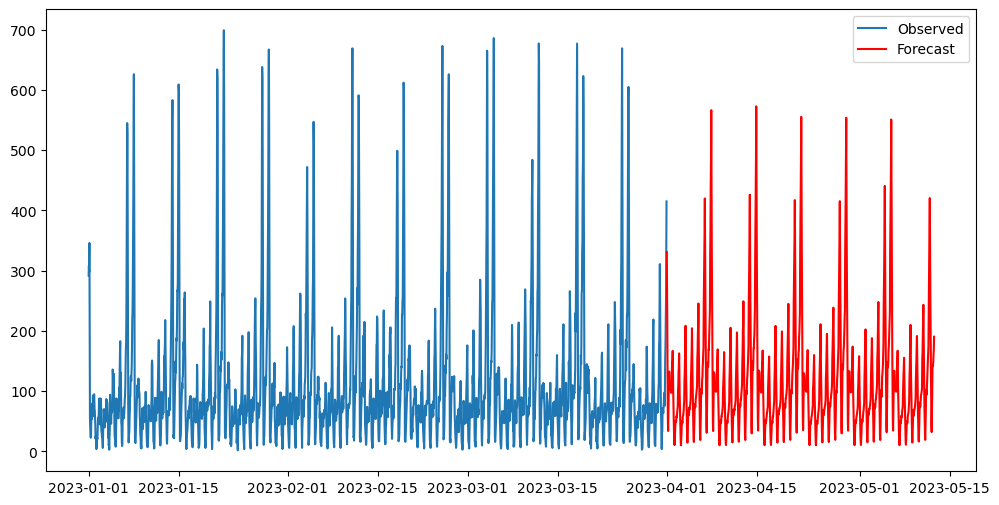

In [102]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Example time series data (counts per hour for one week)
# Replace this array with your actual data
ts_1_p['log_counts'] = np.log(ts_1_p['counts'])
ts_data = ts_1_p['log_counts']

def create_fourier_terms(series, period, K):
    t = np.arange(len(series))
    terms = pd.DataFrame({
        f'sin_{i}': np.sin(2 * np.pi * i * t / period) for i in range(1, K + 1)
    }).join(pd.DataFrame({
        f'cos_{i}': np.cos(2 * np.pi * i * t / period) for i in range(1, K + 1)
    }))
    return terms

# Create Fourier terms for daily (24-hour) and weekly (168-hour) seasonality
fourier_list = [create_fourier_terms(ts_data, period=period, K=5) for period in [24, 24*7, 12, 8, 6, 5]]

# Combine exogenous variables
exog = pd.concat(fourier_list, axis=1)
exog.index = ts_data.index

# Fit SARIMAX model with exogenous variables for multiple seasonalities
sarimax_model = sm.tsa.statespace.SARIMAX(ts_data, order=(2, 1, 1), exog=exog).fit()

# Print model summary
print(sarimax_model.summary())

# Forecasting
future_exog = pd.concat([create_fourier_terms(ts_data, period=period, K=5).iloc[:1000] for period in [24, 24*7, 12, 8, 6, 5]], axis=1)
forecast = sarimax_model.get_forecast(steps=1000, exog=future_exog)
forecast_index = pd.date_range(start=ts_data.index[-1], periods=1000, freq='H')[1:]
forecast_series = pd.Series(forecast.predicted_mean, index=forecast_index)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(np.exp(ts_data), label='Observed')
plt.plot(np.exp(forecast_series), label='Forecast', color='red')
plt.legend()
plt.show()



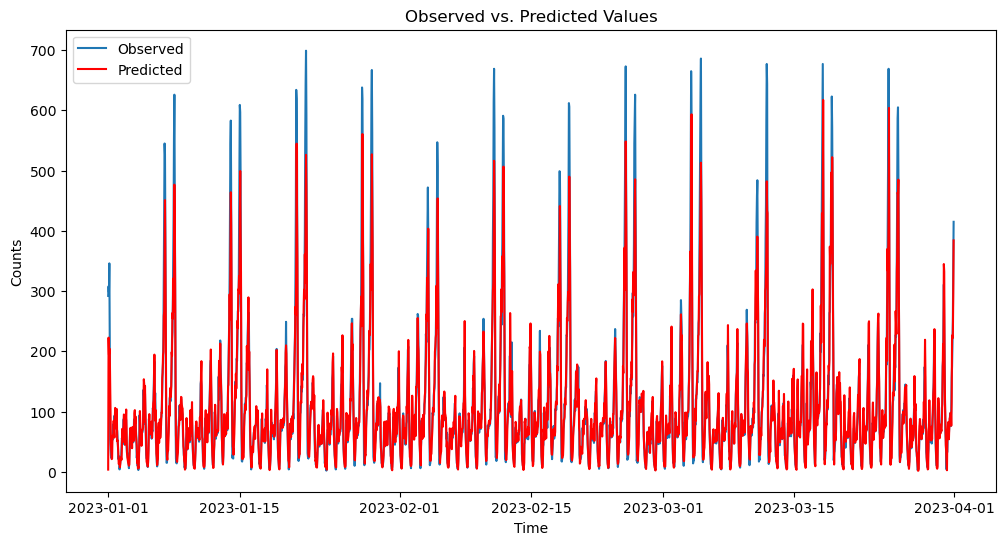

In [103]:
# Generate in-sample predictions
in_sample_predictions = sarimax_model.get_prediction(start=0, end=len(ts_data)-1, exog=exog)
predicted_mean = in_sample_predictions.predicted_mean

# Calculate residuals
residuals = ts_data - predicted_mean

# Plot observed vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(np.exp(ts_data), label='Observed')
plt.plot(np.exp(predicted_mean), label='Predicted', color='red')
plt.legend()
plt.title('Observed vs. Predicted Values')
plt.xlabel('Time')
plt.ylabel('Counts')
plt.show()

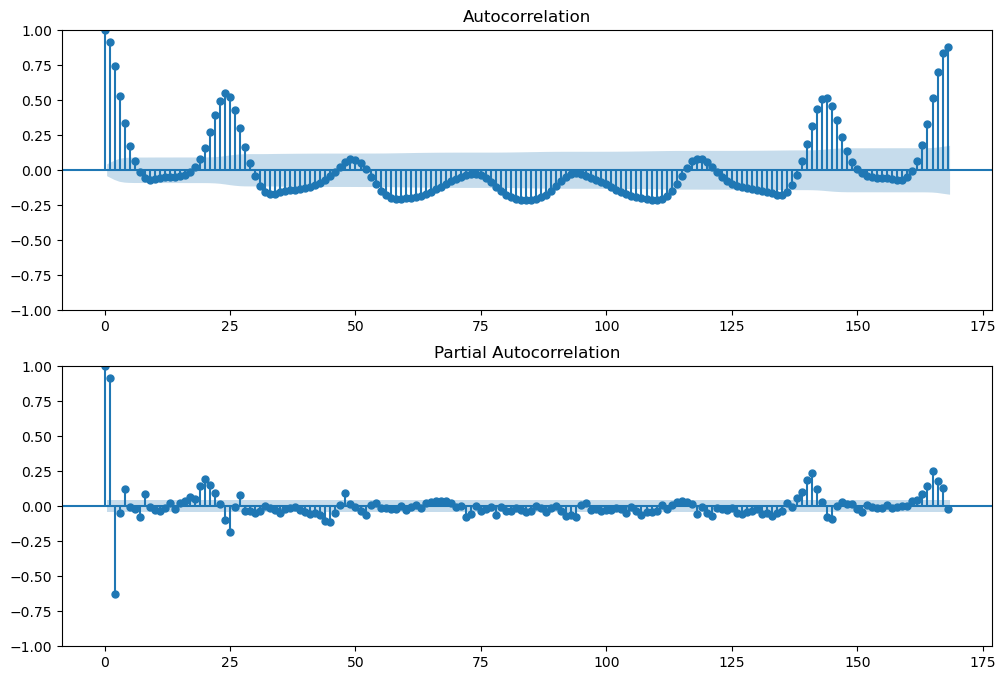

In [104]:
# calculate acf and pacf of residuals
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF of residuals
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(np.exp(ts_data) - predicted_mean, lags=24*7, ax=ax[0])
plot_pacf(np.exp(ts_data) - predicted_mean, lags=24*7, ax=ax[1])
plt.show()

In [106]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Example time series data (counts per hour for one week)
# Replace this array with your actual data
ts_1_p['log_counts'] = np.log(ts_1_p['counts'])
ts_data = ts_1_p['log_counts']

def create_fourier_terms(series, period, K):
    t = np.arange(len(series))
    terms = pd.DataFrame({
        f'sin_{i}': np.sin(2 * np.pi * i * t / period) for i in range(1, K + 1)
    }).join(pd.DataFrame({
        f'cos_{i}': np.cos(2 * np.pi * i * t / period) for i in range(1, K + 1)
    }))
    return terms

# Create Fourier terms for daily (24-hour) and weekly (168-hour) seasonality
fourier_list = [create_fourier_terms(ts_data, period=period, K=5) for period in [24, 24*7, 12, 8, 6, 5]]

# Combine exogenous variables
exog = pd.concat(fourier_list, axis=1)
exog.index = ts_data.index

# Fit SARIMAX model with exogenous variables for multiple seasonalities
sarimax_model = sm.tsa.statespace.SARIMAX(ts_data, order=(2, 1, 1), exog=exog).fit()


/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           64     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.28573D-01    |proj g|=  1.25203D-01


 This problem is unconstrained.



At iterate    5    f=  4.22364D-01    |proj g|=  6.98517D-02

At iterate   10    f=  4.20763D-01    |proj g|=  7.83450D-02

At iterate   15    f=  4.20336D-01    |proj g|=  8.54291D-02

At iterate   20    f=  4.20048D-01    |proj g|=  6.61944D-02

At iterate   25    f=  4.19926D-01    |proj g|=  5.05307D-02

At iterate   30    f=  4.19726D-01    |proj g|=  5.27263D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   64     34     82      1     0     0   7.937D-02   4.197D-01
  F =  0.41969460644327505     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [127]:
from datetime import timedelta
# Forecasting
future_exog = pd.concat([create_fourier_terms(ts_data, period=period, K=5).iloc[:24] for period in [24, 24*7, 12, 8, 6, 5]], axis=1)
preds_df = sarimax_model.get_prediction(start = ts_data.index[-1], end = ts_data.index[-1] + timedelta(hours=24), exog=future_exog).summary_frame(alpha = 0.05)
pred_index = pd.date_range(start=ts_data.index[-1], periods=24, freq='H')[1:]

/tmp/ipykernel_20961/1307272194.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  pred_index = pd.date_range(start=ts_data.index[-1], periods=24, freq='H')[1:]


In [128]:
preds_df

log_counts,mean,mean_se,mean_ci_lower,mean_ci_upper
2023-03-31 23:00:00-04:00,5.950875,0.368513,5.228602,6.673148
2023-04-01 00:00:00-04:00,5.802085,0.368513,5.079812,6.524359
2023-04-01 01:00:00-04:00,5.542425,0.539781,4.484474,6.600377
2023-04-01 02:00:00-04:00,5.060956,0.694032,3.700679,6.421234
2023-04-01 03:00:00-04:00,4.587994,0.822000,2.976904,6.199085
2023-04-01 04:00:00-04:00,3.969253,0.934843,2.136994,5.801511
2023-04-01 05:00:00-04:00,3.527555,1.035727,1.497567,5.557543
2023-04-01 06:00:00-04:00,4.178930,1.127840,1.968404,6.389456
2023-04-01 07:00:00-04:00,4.549269,1.213010,2.171814,6.926724
2023-04-01 08:00:00-04:00,4.867932,1.292602,2.334479,7.401386


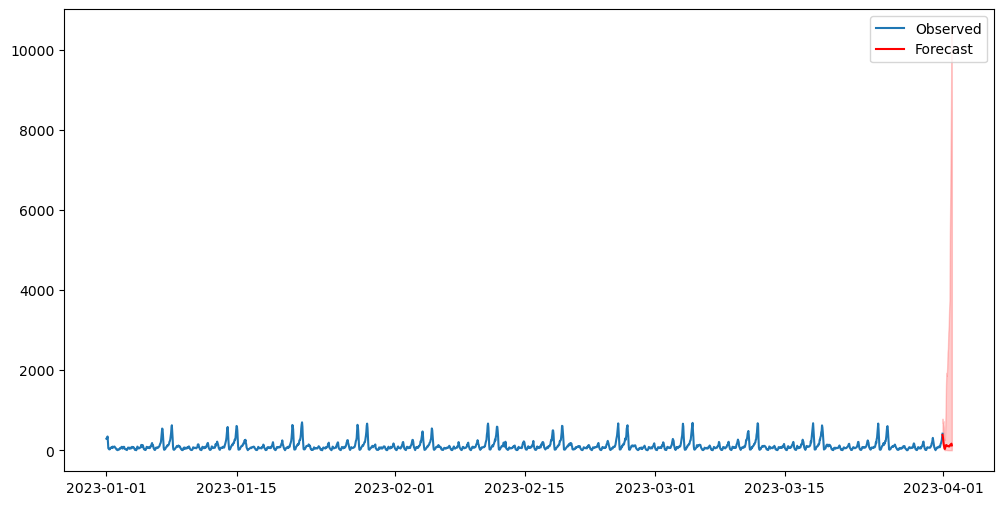

In [129]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(ts_data.index, np.exp(ts_data), label='Observed')
plt.plot(preds_df.index, np.exp(preds_df['mean']), label='Forecast', color='red')
plt.fill_between(preds_df.index, np.exp(preds_df['mean_ci_lower']), np.exp(preds_df['mean_ci_upper']), color='red', alpha=0.2)
plt.legend()
plt.show()

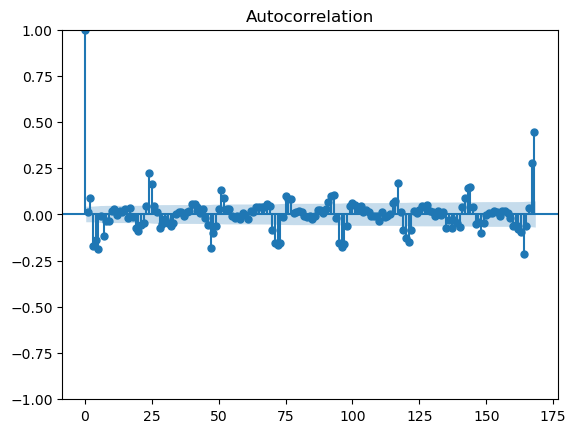

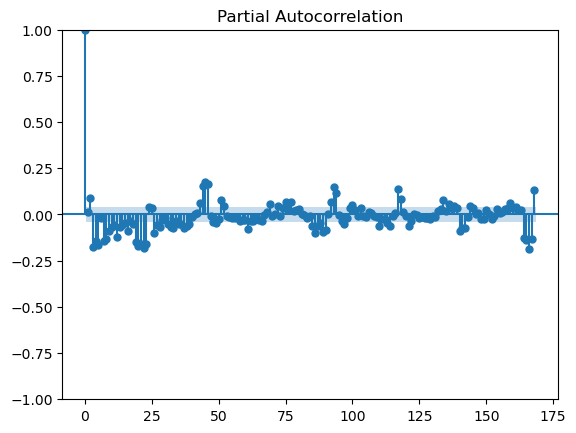

In [41]:
# check acf and pacf of residuals
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(residuals, lags=24*7)
plt.show()

plot_pacf(residuals, lags=24*7)
plt.show()

In [24]:
# Fit model
# Weekly seasonality covered by SARIMAX
arima_exog_model = auto_arima(y=y_prime, D=1, exogenous=exog, seasonal=True, m=24)

# # Forecast
# y_arima_exog_forecast = arima_exog_model.predict(n_periods=24*7, exogenous=exog)
# y_arima_exog_forecast = pd.DataFrame(y_arima_exog_forecast , index = pd.date_range(start='2023-01-01', end= '2023-03-30'))

# # Plots
# plt.plot(y_prime, label='Actual data')
# plt.plot(y_arima_exog_forecast, label='Forecast')
# plt.legend()

KeyboardInterrupt: 

(464592.0, 465984.0)

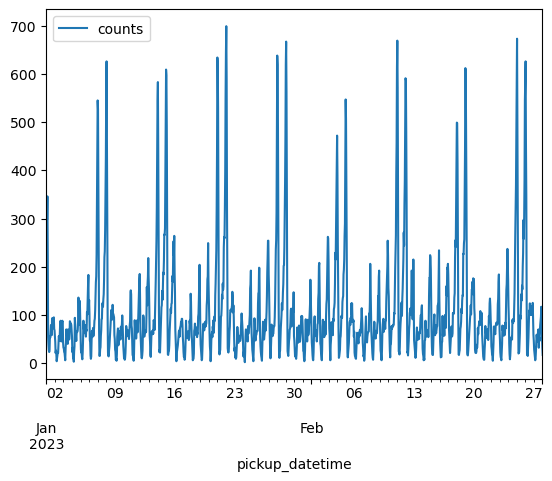

In [31]:
ts_1.plot(x = 'pickup_datetime', y = 'counts')
plt.xlim('2023-01-01', '2023-02-28')

In [45]:
df_H_y_z_1 = ts_H_y_z[ts_H_y_z['PULocationID'] == 1]

In [46]:
ts

counts
PULocationID pickup_datetime                  
1            2022-01-01 00:00:00-05:00     0.0
             2022-01-01 01:00:00-05:00     0.0
             2022-01-01 02:00:00-05:00     0.0
             2022-01-01 03:00:00-05:00     0.0
             2022-01-01 04:00:00-05:00     1.0
...                                        ...
265          2022-03-31 19:00:00-04:00    11.0
             2022-03-31 20:00:00-04:00     8.0
             2022-03-31 21:00:00-04:00     6.0
             2022-03-31 22:00:00-04:00     7.0
             2022-03-31 23:00:00-04:00     8.0

[553519 rows x 1 columns]

In [4]:
# load two datasets and combine them
df_1 = pr.load_taxi_data(month = 1, year = 2023, vehicle_type = 'yellow')
df_2 = pr.load_taxi_data(month = 2, year = 2023, vehicle_type = 'yellow')

In [5]:
# remove rows with year not equal to 2023 and within January
df_y = df_y[(df_y.pickup_datetime.dt.year == 2023) & (df_y.pickup_datetime.dt.month == 1)]
df_y.pickup_datetime.sort_values().head()

In [19]:
pd.to_datetime('2023-01-01 00:00:00')

Timestamp('2023-01-01 00:00:00')

In [22]:
len(df_y[(df_y.tpep_pickup_datetime < pd.to_datetime('2023-01-01 00:00:00'))]) / len(df_y)

1.2390902990316182e-05

In [13]:
# count by taxi zone
ts_H_1 = df_1.set_index('tpep_pickup_datetime').groupby(['PULocationID', pd.Grouper(freq='h')]).size()
ts_h_1 = ts_H_1.to_frame(name = 'counts')
ts_h_1.head()

counts
PULocationID tpep_pickup_datetime        
1            2022-10-24 17:00:00        1
             2022-10-25 03:00:00        1
             2023-01-01 05:00:00        1
             2023-01-01 08:00:00        1
             2023-01-01 11:00:00        1

In [ ]:
# do the same for df_2
ts_H_2 = df_2.set_index('tpep_pickup_datetime').groupby(['PULocationID', pd.Grouper(freq='h')]).size()
ts_h_2 = ts_H_2.to_frame(name = 'counts')
ts_h_2.head()

In [6]:
print(df_1.tpep_pickup_datetime.sort_values().head())
print('\n ')
print('Min: ' + str(df_1.tpep_pickup_datetime.sort_values().min()), ', Max: ' + str(df_1.tpep_pickup_datetime.sort_values().max()))

2138036   2008-12-31 23:01:42
209091    2008-12-31 23:04:41
10023     2022-10-24 17:37:47
18219     2022-10-24 20:01:46
21660     2022-10-24 21:45:35
Name: tpep_pickup_datetime, dtype: datetime64[us]

 
Min: 2008-12-31 23:01:42 , Max: 2023-02-01 00:56:53


In [7]:
print(df_2.tpep_pickup_datetime.sort_values().head())
print('\n ')
print('Min: ' + str(df_2.tpep_pickup_datetime.sort_values().min()), ', Max: ' + str(df_2.tpep_pickup_datetime.sort_values().max()))

2638356   2008-12-31 23:05:06
2725408   2008-12-31 23:06:21
2661017   2008-12-31 23:11:10
1387271   2008-12-31 23:43:40
1312010   2009-01-01 00:05:14
Name: tpep_pickup_datetime, dtype: datetime64[us]

 
Min: 2008-12-31 23:05:06 , Max: 2023-03-07 13:01:28


In [8]:
psutil

NameError: name 'psutil' is not defined

In [ ]:
print(df_y.pickup_datetime.sort_values().head())
print('\n ')
print('Min: ' + str(df_y.pickup_datetime.sort_values().min()), ', Max: ' + str(df_y.pickup_datetime.sort_values().max()))